# Discontinuous Galerkin Methods
So far we have been using Lagrange spaces of different order to solve our
PDE. In the following we show how to use Discontinuous Galerkin method to
solve an advection dominated advection-diffusion probllem:
\begin{align*}
-\varepsilon\triangle u + b\cdot\nabla u &= f
\end{align*}
with Dirichlet boundary conditions. Here $\varepsilon$ is a small
constant and $b$ a given vector.

In [1]:
import numpy, math
import dune.plotting
dune.plotting.block = True
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot
from dune.grid import structuredGrid as leafGridView
from dune.fem.space import dglegendre as dgSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.ufl import Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate, triangle, FacetNormal
from ufl import dx, ds, grad, div, grad, dot, inner, sqrt, exp, conditional
from ufl import as_vector, avg, jump, dS, CellVolume, FacetArea, atan

gridView      = leafGridView([-1, -1], [1, 1], [20, 20])
order = 2
space = dgSpace(gridView, order=order)

u    = TrialFunction(space)
v    = TestFunction(space)
n    = FacetNormal(space)
he   = avg( CellVolume(space) ) / FacetArea(space)
hbnd = CellVolume(space) / FacetArea(space)
x    = SpatialCoordinate(space)

# diffusion factor
eps = Constant(0.1,"eps")
# transport direction and upwind flux
b    = as_vector([1,0])
hatb = (dot(b, n) + abs(dot(b, n)))/2.0
# boundary values (for left/right boundary)
dD   = conditional((1+x[0])*(1-x[0])<1e-10,1,0)
g    = conditional(x[0]<0,atan(10*x[1]),0)
# penalty parameter
beta = 10*order*order

aInternal     = dot(eps*grad(u) - b*u, grad(v)) * dx
diffSkeleton  = eps*beta/he*jump(u)*jump(v)*dS -\
                eps*dot(avg(grad(u)),n('+'))*jump(v)*dS -\
                eps*jump(u)*dot(avg(grad(v)),n('+'))*dS
diffSkeleton += eps*beta/hbnd*(u-g)*v*dD*ds -\
                eps*dot(grad(u),n)*v*dD*ds
advSkeleton   = jump(hatb*u)*jump(v)*dS
advSkeleton  += ( hatb*u + (dot(b,n)-hatb)*g )*v*dD*ds
form          = aInternal + diffSkeleton + advSkeleton

scheme = solutionScheme(form==0, solver="gmres",
            parameters={"newton.linear.preconditioning.method":"jacobi"})
uh = space.interpolate(0, name="solution")
scheme.solve(target=uh)
uh.plot()

<Figure size 640x480 with 2 Axes>

So far the example was not really advection dominated so we now
repeat the experiment but set $\varepsilon=1e-5$

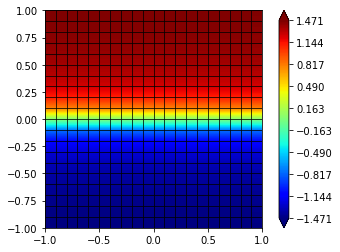

In [2]:
eps.value = 1e-5 # could also use scheme.model.eps = 1e-5
scheme.solve(target=uh)
uh.plot()

# A 3D Example Using a GMesh File
In this example we use pygmsh to construct a tetrahedral mesh and olve a
simple laplace problem

In [3]:
# The following code is taken from the `pygmsh` homepage
from dune.fem.space import lagrange as solutionSpace
try:
    import pygmsh
    geom = pygmsh.built_in.Geometry()
    poly = geom.add_polygon([
          [ 0.0,  0.5, 0.0], [-0.1,  0.1, 0.0], [-0.5,  0.0, 0.0],
          [-0.1, -0.1, 0.0], [ 0.0, -0.5, 0.0], [ 0.1, -0.1, 0.0],
          [ 0.5,  0.0, 0.0], [ 0.1,  0.1, 0.0] ], lcar=0.05)
    axis = [0, 0, 1]
    geom.extrude( poly, translation_axis=axis, rotation_axis=axis,
          point_on_axis=[0, 0, 0], angle=2.0 / 6.0 * numpy.pi)
    mesh = pygmsh.generate_mesh(geom, verbose=False)
    points, cells = mesh.points, mesh.cells
    domain3d = {"vertices":points, "simplices":cells["tetra"]}
except ImportError: # pygmsh not installed - use a simple cartesian domain
    from dune.grid import cartesianDomain
    domain3d = cartesianDomain([-0.25,-0.25,0],[0.25,0.25,1],[30,30,60])

from dune.alugrid import aluSimplexGrid as leafGridView3d
gridView3d  = leafGridView3d(domain3d)
space3d = solutionSpace(gridView3d, order=1)

from ufl import conditional
u = TrialFunction(space3d)
v = TestFunction(space3d)
x = SpatialCoordinate(space3d)
scheme3d = solutionScheme((inner(grad(u),grad(v))+inner(u,v))*dx ==
                        conditional(dot(x,x)<.01,100,0)*v*dx,
                        solver='cg')

uh3d = space3d.interpolate([0],name="solution")
scheme3d.solve(target=uh3d)
# note: plotting with matplotlib not yet available for 3d grids
gridView3d.writeVTK('3dexample', pointdata=[uh3d])

![3d laplace problem](figures/3dexample.png)

# We Can Also Do 1D

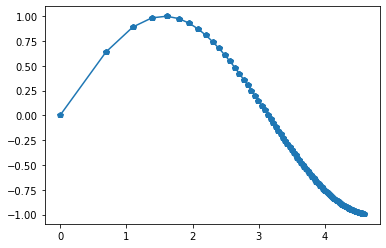

In [4]:
from dune.grid import onedGrid
from ufl import sin
v = [math.log(i) for i in range(1,100)]
e = [(i,i+1) for i in range(1,len(v))]
g = onedGrid(constructor={"vertices":v, "simplices":e})
s = solutionSpace(g)
x = SpatialCoordinate(s)
u = s.interpolate(sin(x[0]), name="u")
pyplot.plot(g.tesselate()[0], u.pointData(), '-p')
pyplot.show()